In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    RemoveMessage,
    SystemMessage,
    ToolMessage,
)

In [98]:
load_dotenv(override=True)

True

In [99]:
llm = init_chat_model("openai:gpt-4.1", temperature=0.7, max_retries=3, output_version="responses/v1")

In [100]:
system_prompt = """

You are an expert on Python Data Science and Machine Learning code generation. Here are the rules 
you must follow when generating code:

- Return only code, no preembale or postamble.
- Code should be Python3 unless stated otherwise. 
- Any comments or explanations should be inline with the code.
- Only use Python Standard library, Numpy, Matplotlib, Pandas, Scikit-Learn and Pytorch
- Generated images and plots should be saved to files, not displayed.
- Avoid using third-party packages, when in doubt, ask.
- Code should be complete and fully runnable
- Code should be PEP8 compliant
- Code, classes, function and methods should have complete Docstrings.
- Beautiful is better than ugly.
- Explicit is better than implicit.
- Simple is better than complex.
- Readability counts.
- In the face of ambiguity, refuse the temptation to guess.
- If the implementation is hard to explain, it's a bad idea.
- If the implementation is easy to explain, it may be a good idea. 
"""

In [101]:
tools = (
    [
        {"type": "code_interpreter", "container": {"type": "auto"}},
        {"type": "web_search_preview"},
    ],
)

In [102]:
import json
import re
from typing import Dict, List, Any


def parse_dataframe_info(info_output: str) -> str:
    """
    Parse the string output of DataFrame.info() into a JSON object.
    
    This function extracts column information from pandas DataFrame.info() output,
    ignoring the header lines and footer statistics. It focuses only on parsing
    the column details including index, name, non-null count, and data type.
    
    Args:
        info_output (str): The string output from DataFrame.info()
        
    Returns:
        str: JSON string containing parsed column information
        
    Raises:
        ValueError: If the input format is not recognized or cannot be parsed
    """
    lines = info_output.strip().split('\n')
    columns_data = []
    
    # Find the start of column data (skip first 3 lines)
    column_start_index = 3
    
    # Find where column data ends (before dtypes: or memory usage:)
    column_end_index = len(lines)
    for i, line in enumerate(lines[column_start_index:], column_start_index):
        if line.strip().startswith('dtypes:') or line.strip().startswith('memory usage:'):
            column_end_index = i
            break
    
    # Parse each column line
    for line in lines[column_start_index:column_end_index]:
        line = line.strip()
        
        # Skip separator lines (lines with only dashes and spaces)
        if re.match(r'^[-\s]+$', line) or not line:
            continue
            
        # Parse column information using regex
        # Pattern matches: index, column_name, non_null_count, dtype
        pattern = r'^\s*(\d+)\s+(\S+)\s+(\d+)\s+non-null\s+(\S+)\s*$'
        match = re.match(pattern, line)
        
        if match:
            column_index = int(match.group(1))
            column_name = match.group(2)
            non_null_count = int(match.group(3))
            dtype = match.group(4)
            
            column_info = {
                'index': column_index,
                'column_name': column_name,
                'non_null_count': non_null_count,
                'dtype': dtype
            }
            
            columns_data.append(column_info)
    
    # Create the final JSON structure
    result = {
        'columns': columns_data,
        'total_columns': len(columns_data)
    }
    
    return json.dumps(result, indent=2)


def parse_dataframe_info_to_dict(info_output: str) -> Dict[str, Any]:
    """
    Parse the string output of DataFrame.info() into a Python dictionary.
    
    This function is similar to parse_dataframe_info() but returns a dictionary
    instead of a JSON string, which can be more convenient for further processing.
    
    Args:
        info_output (str): The string output from DataFrame.info()
        
    Returns:
        Dict[str, Any]: Dictionary containing parsed column information
        
    Raises:
        ValueError: If the input format is not recognized or cannot be parsed
    """
    json_string = parse_dataframe_info(info_output)
    return json.loads(json_string)




In [103]:
import io

df = pd.read_csv("assets/simpsons_episodes.csv")
buffer = io.StringIO()
df.info(buf=buffer, show_counts=True, memory_usage="deep")
df_json = parse_dataframe_info_to_dict(buffer.getvalue())


In [113]:
system_message = SystemMessage(
    content=system_prompt,
)

human_message = HumanMessage(
    content="Provide Python code that will rank the top 10 episodes by us viewers and plot" \
    "Assume the dataframe has been loaded and is available as `df`." \
    "Structured of the DataFrame:\n" +
    json.dumps(df_json, indent=2))
messages = [system_message, human_message]

In [114]:
from pydantic import BaseModel, Field

class CodeResponse(BaseModel):
    code: str = Field(description="The setup of the joke")


In [115]:
structured_llm = llm.with_structured_output(schema=CodeResponse)

In [116]:
resp = structured_llm.invoke(messages, tools=tools[0])

In [117]:
print(resp.code)

import pandas as pd
import matplotlib.pyplot as plt

# Drop rows where 'us_viewers_in_millions' is NaN
filtered_df = df.dropna(subset=['us_viewers_in_millions'])

# Get top 10 episodes by US viewers
top10 = filtered_df.nlargest(10, 'us_viewers_in_millions')

# Sort for prettier plot (descending order)
top10 = top10.sort_values('us_viewers_in_millions', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top10['title'], top10['us_viewers_in_millions'], color='skyblue')
plt.xlabel('US Viewers (millions)')
plt.ylabel('Episode Title')
plt.title('Top 10 Episodes by US Viewers')
plt.tight_layout()
plt.savefig('top10_us_viewers.png')



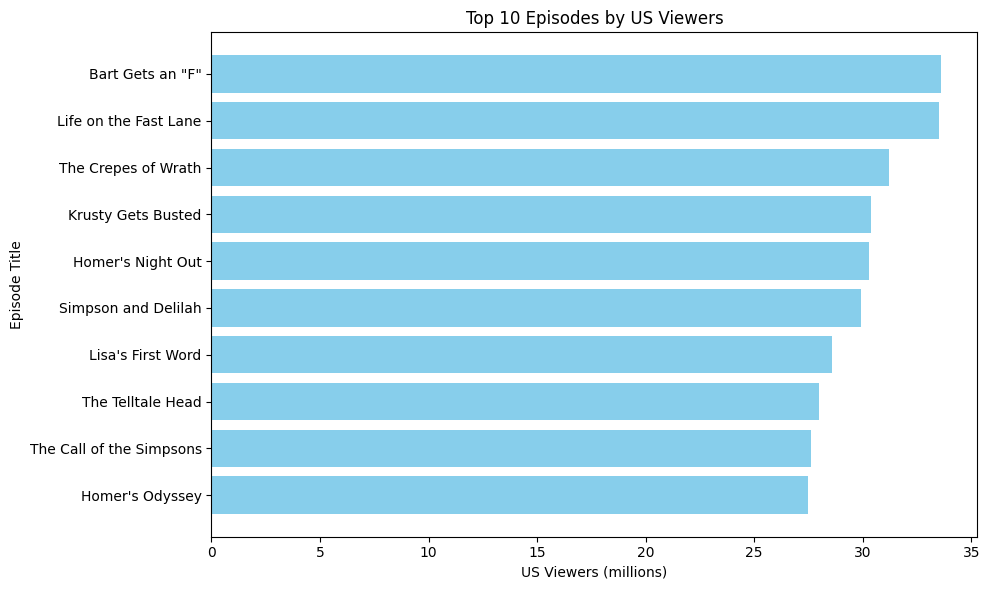

In [118]:
import pandas as pd
import matplotlib.pyplot as plt

# Drop rows where 'us_viewers_in_millions' is NaN
filtered_df = df.dropna(subset=['us_viewers_in_millions'])

# Get top 10 episodes by US viewers
top10 = filtered_df.nlargest(10, 'us_viewers_in_millions')

# Sort for prettier plot (descending order)
top10 = top10.sort_values('us_viewers_in_millions', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top10['title'], top10['us_viewers_in_millions'], color='skyblue')
plt.xlabel('US Viewers (millions)')
plt.ylabel('Episode Title')
plt.title('Top 10 Episodes by US Viewers')
plt.tight_layout()
plt.savefig('top10_us_viewers.png')

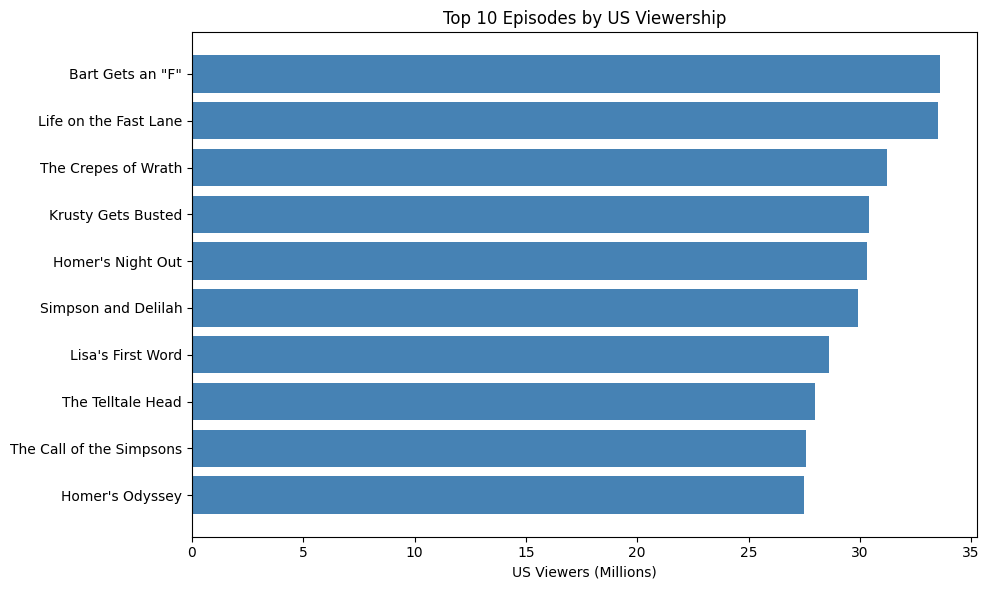

In [90]:
import os
import httpx
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

url = "https://raw.githubusercontent.com/Walendziak1912/Simpson-DataSets/master/simpsons_episodes.csv"

# Use httpx (requests won't work in Pyodide)
response = httpx.get(url)
response.raise_for_status()

# Save to file
with open("simpsons.csv", "w", encoding="utf-8") as f:
    f.write(response.text)

df = pd.read_csv(r'simpsons.csv')
# Drop rows with missing US viewers
df_clean = df.dropna(subset=['us_viewers_in_millions'])

# Get top 10 episodes by US viewers
top_10 = df_clean.nlargest(10, 'us_viewers_in_millions')

# Sort for better plotting (highest at top)
top_10_sorted = top_10.sort_values('us_viewers_in_millions', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_sorted['title'], top_10_sorted['us_viewers_in_millions'], color='steelblue')
plt.xlabel('US Viewers (Millions)')
plt.title('Top 10 Episodes by US Viewership')
plt.tight_layout()
plt.savefig('top_10_us_viewers.png')